En este notebook implementamos la simulación numérica de un modelo de difusión en grafos no dirigidos y simples. El modelo que implementamos es

$$
\dot{C}(t) = B dB^T C(t)  \tag{1}
$$

Donde:

* $C(t)$ es el vector de concentraciones; nos indica cuánta información tiene cierto nodo en un tiempo $t$.

* $\dot{C}(t)$ es el vector del cambio en las concentraciones del vector de concentraciones.

* $B$ es la matriz de incidencia para **grafos no dirigidos**, aquella que tiene unos y ceros. Es de tamaño $|V| \times |E|$.

* La matriz $d$ es una matriz cuadrada y diagonal de tamaño $|E| \times |E|$. A esta le llamamos matriz de coeficientes de difusión, pues en sus entradas diagonales tendrá el coeficiente de difusión de cierta arista. Sus entradas deben ser no positivas.

Además, implementamos funciones que calculan la curvatura de Forman-Ricci de los grafos sobre los que ocurre el proceso de difusión.


In [ ]:
# Usamos las bibliotecas básicas para trabajar con grafos en Python, además tenemos visualizaciones en 3D, por lo que usamos Plotly.

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import string

Para implementar el comportamiento del modelo debemos conocer la solución de la ecuación (1), esta es la siguiente:

$$
C(t) = e^{BdB^T t} C(0) \tag{2}
$$

Utilizando las propiedades de la matriz $BdB^T$ y el llamado teorema espectral, podemos reescribir (2) como:

$$
C(t) = P e^{\Lambda t} P^{-1} \tag{3}
$$

Aquí, la matriz $P$ es la matriz que conforman los autovectores de $BdB^T$ y $P^{-1}$ su inversa. La matriz $e^{\Lambda t}$ es una matriz diagonal cuyas entradas son todas exponenciales elevadas a alguno de sus autovalores por la variable del tiempo t.

Esta es la función principal, calcula los autovectores para hacer la matriz $P$, además de su inversa. Estas son constantes durante toda la ejecución. Con los autovalores, calcula la matriz $e^{\Lambda t}$, la cual va dentro de un ciclo `for` que varía $t$, por lo que en cada iteración calculamos un $C(t)$. Además, tiene varias funciones auxiliares que sirven para distintas cosas; la explicación de cada una de ellas aparece más adelante.

In [ ]:
"""
La función recibe los siguientes parámetros:

A (Array de NumPy bidimensional): Matriz de adyacencia.
d (Array de NumPy unidimensional): Array con los coeficientes de difusión.
C0 (Array de NumPy unidimensional): Vector de concentraciones iniciales.
Tiempo (Entero positivo): Cantidad de tiempo que se desea simular.
Tolerancia (Número entero o float positivo): Tolerancia para el criterio de paro.
Semilla (Número entero positivo): Una semilla para reproducir resultados aleatorios.
K (Número positivo): Es un parámetro que sirve para la visualización, controla qué tan separados estarán los vértices al imprimir el grafo.
Escalar (True o False): Es un parámetro para la visualización 3D. Si es True, se plotea el grafo en 3D con las curvaturas sobre las aristas de tal forma que aparecen en una altura de 0 a 1. Si es False, aparecen por debajo de las aristas tan profundamente como el valor de la curvatura de esa arista.

La función tiene algunas partes comentadas que sirven para mostrar información de matrices, vectores o ciertas cantidades. Si se trabaja con dimensiones pequeñas, es útil para ver el proceso. Con matrices de dimensiones altas no es viable descomentarlas, ya que tardaría demasiado en imprimir la información.
"""

def Difusion(A,d,C0,Tiempo,Tolerancia,Semilla,K,Escalar):


  #Obtenemos las etiquetas de los vertices usando la funcion Diccionario
  Etiquetas = Diccionario(len(C0))

  # Hacemos un grafo a partir de la matriz de adyacencia
  G = nx.convert_matrix.from_numpy_array(A)

  #Calculamos las curvaturas de las aristas del grafo haciendo uso de la funcion Curvatura, la variable Curvaturas es un dataframe con esa información
  Curvaturas=Curvatura(G)

  #Asignamos las etiquetas a los vertices
  G = nx.relabel_nodes(G, Etiquetas)

  #Obtenemos la matriz de incidencia para grafos no dirigidos
  B = nx.incidence_matrix(G, oriented=False).toarray()


  #Descomentar para ver la matriz de incidencia del grafo
  """print("Matriz de incidencia: \n")
  print(B.toarray())"""

  #Obtenemos la matriz BdB^T, la llamaremos L
  L = np.dot(np.dot(B,d),B.T)

  #Descomentar para ver la matriz BdB^T del grafo
  """print("Matriz BdB^T: \n")
  print(L)"""

  #Enumeramos las aristas, edge nos regresara duplas tipo ('A','B') ('E','G'), con el indice i las enumeraremos alfabeticamente, hacemos esto para darle los nombres a las columnas de la tabla
  #de flujos que calculamos mas adelante
  aristas = {edge: f"{i+1}" for i, edge in enumerate(G.edges())}

  # Obtenemos los eigenvalores y eigenvectores
  eigenvalores, eigenvectores = np.linalg.eig(L)

  #Si nos interesa conocer los eigenvalores o eigenvectores descomentamos esta parte

  """
  print("Los eigenvalores ordenados de menor a mayor son :\n")
  print(np.sort(eigenvalores))
  print("Los eigenvectores son:")
  print(eigenvectores)
  """

  #Para presentar la evolución del proceso haremos un dataframe en donde el indice sea el tiempo y las columnas representen la cantidad de concentración en ese vertice.
  Evolucion = pd.DataFrame(columns=list(Etiquetas.values()))

  #Ademas podemos obtener un dataframe del flujo que se calcula usando dB^TC(t) , esta tabla nos dira cuanta concentracion pasa por las aristas en un tiempo t
  Flujo=pd.DataFrame(columns=list(aristas.keys()))

  #Aqui hacemos las etiquetas con las duplas de antes ('A','B') y se las asignamos al dataframe Curvaturas
  Aristas=[str(Arista) for Arista in aristas.keys()]
  Curvaturas.index=Aristas

  #Ahora definimos cuantos puntos en el intervalo de tiempo (0,Tiempo) queremos analizar, es decir, cuantos tiempos t dentro de ese intervalo usaremos para calcular
  #su respectivo C(t), como estamos en el caso continuo se recomienda que sean bastantes. Nosotros definimos por default 60 pero puede ajustarse
  S=60
  T = np.linspace(0, Tiempo, num=S)

  #Obtengo la inversa de la matriz de eigenvectores
  eigenvectoresInv=np.linalg.inv(eigenvectores)

  #Este for es el que simula el proceso, en cada t calculamos el vector C(t) asi como el flujo de las aristas y las guardamos en sus dataframes, usaremos tantas t como
  #hayamos definido o acabara antes si se considera que el proceso ya alcanzo un estado de estabilidad
  for t in T :
    #Inicializamos la matriz e^{BdB^T} creando una matriz nula de tamaño |V| x |V|
    e_tL=np.zeros((len(C0),len(C0)))

    #Construimos la matriz exponencial con los eigenvalores multiplicandolos por la t en turno
    e_i=np.diag(np.exp(t*eigenvalores))

    #Construimos la matriz e^{BdB^T} haciendo el producto de matrices
    e_tL=np.dot(np.dot(eigenvectores, e_i ),eigenvectoresInv)

    #Calculamos el vector C(t) multiplicando e^{BdB^T * t} por C0 y lo guardamos
    Evolucion.loc[len(Evolucion)] = np.real(np.dot(e_tL,C0))

    #Calculamos dB^TC0 para obtener informacion del flujo en t y lo guardamos
    Flujo.loc[len(Flujo)] = -1*np.dot(np.dot(d,B.T),Evolucion.iloc[len(Evolucion)-1].values)

    #Enviamos a la funcion Criterio_Paro el vector C(t) y C(t-1) para ver si podemos detener el proceso. Hacemos esto para todas las iteraciones despues de la primera
    if t!=0 and Criterio_Paro(Evolucion.iloc[len(Evolucion)-1].to_numpy(),Evolucion.iloc[len(Evolucion)-2].to_numpy(),Tolerancia):
      break



  #En esta seccion imprimimos la informacion resumida
  print("Vector de concentraciones inicial: ",C0)

  print("\nEvolucion del vector de concentraciones: \n")

  #Aqui le damos un poco de formato a las tablas colocando los indices temporales
  Evolucion["Tiempo"]=T[:len(Evolucion)]
  Evolucion=Evolucion.set_index("Tiempo")
  Flujo["Tiempo"]=T[:len(Flujo)]
  Flujo=Flujo.set_index("Tiempo")
  print(Evolucion)
  print(Flujo)

  #Mostramos la grafica de como fueron cambiando las concentraciones
  print("\nLa grafica es :")

  pos = nx.spring_layout(G)  # Posicionamiento de los nodos, solo hace que no haya tantas intersecciones entre aristas
  nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, edge_color='black', font_size=15, font_weight='bold')

  Evolucion.plot(figsize=(10, 6))
  plt.xlabel('Tiempo')
  plt.ylabel('Concentración')
  plt.title('Evolución de concentraciones en el tiempo')
  plt.legend()
  plt.grid()
  plt.show()

  #Esta seccion de aqui es por si se quieren investigar mas a fondo las curvaturas de las aristas del grafo

  #Imprime la tabla de las curvaturas de las aristas
  #print(Curvaturas)

  #Imprime un histograma con la frecuencia de los valores de las curvaturas
  #print(Barras(Curvaturas))

  #Imprime en 2 dimensiones el grafo con los valores de las curvaturas puestas en las aristas
  #Curvas2D(G,Curvaturas.values.reshape(1,-1)[0],Semilla,K)

  #Imprime en 3 dimensiones el grafo con los valores de las aristas por encima o por debajo del grafo a cierta altura. Es mejor para dimensionar
  #los valores.
  #Curvaturas3D(G,Curvaturas.values.reshape(1,-1)[0],Semilla,K,Escalar)

  #La siguiente funcion es unicamente si se quiere obtener la tabla Curvaturas en Latex
  #LaTex(Curvaturas)

  #Calcula todos los 2-caminos en el grafo y calcula su curvatura total (sumando la curvatura de las dos aristas)
  #Caminos2(G,Curvaturas)

In [ ]:
#Esta funcion calcula las curvaturas de las aristas del grafo G que le sea pasado (debe ser un networkx.Graph). La curvatura
#de Forman-Ricci para grafos es 4-ki-kj en donde ki y kj son los grados de los vertices sobre los que incide la arista (i,j)
def Curvatura(G):
  #Obtenemos la laplaciana de G
  L=nx.laplacian_matrix(G)
  L = L.toarray()
  Curvaturas=[]

  #Iteramos sobre las aristas del grafo
  for i in G.edges():
    #Obtenemos los grados de los nodos sobre los que incide la arista
    k1=L[i[0],i[0]]
    k2=L[i[1],i[1]]
    #Calculamos la curvatura y la añadimos al array
    Curvaturas.append(4-k1-k2)
  #Creamos el dataframe
  dfCurvaturas=pd.DataFrame(Curvaturas,columns=["Curvaturas"])
  return dfCurvaturas

In [ ]:
def Curvas2D(G,Valores_Curvaturas,Semilla,K):
  # Obtenemos las posiciones
  pos = nx.spring_layout(G,seed=Semilla, dim=2,k=K)

  # Tomamos la posicion de cada nodo y los juntamos en arrays de coordenadas separadas x e y
  x = np.array([pos[node][0] for node in G.nodes()])
  y = np.array([pos[node][1] for node in G.nodes()])

  # Creamos el plano 3d
  fig = go.Figure()

  # Añadimos los vertices al gráfico con sus nombres
  fig.add_trace(go.Scatter3d(
      x=x,
      y=y,
      z=np.zeros_like(x),
      mode='markers+text',
      marker=dict(size=10, color='blue'),
      text=[node for node in G.nodes()],
      textposition='top center',
      name='Vertices'
  ))
  i=-1
  # Colocamos las aristas y las curvaturas en medio de las aristas
  for (u, v) in G.edges:
      i+=1
      curvatura = Valores_Curvaturas[i]
      x_coords = [pos[u][0], pos[v][0]]
      y_coords = [pos[u][1], pos[v][1]]

      # Buscamos los puntos medios
      mid_x = (x_coords[0] + x_coords[1]) / 2
      mid_y = (y_coords[0] + y_coords[1]) / 2

      # Añadir la línea de arista
      fig.add_trace(go.Scatter3d(
          x=x_coords,
          y=y_coords,
          z=[0,0],
          mode='lines',
          line=dict(color='gray', width=2),
          name=f'Arista ({u}-{v})'
      ))

      # Añadir el punto en el medio de la arista a la altura del peso
      fig.add_trace(go.Scatter3d(
          x=[mid_x],
          y=[mid_y],
          z=[0],
          mode='markers+text',
          marker=dict(size=4, color='red'),
          text=[f'{curvatura}'],  # Mostrar el peso (valor de z)
          textposition='top center',  # Ajustar la posición del texto
          name=f'Curvatura {curvatura}'
      ))

  fig.update_layout(
    title='Grafo 2D con los valores de las curvas en las aristas',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Curva',
        xaxis=dict(
            backgroundcolor='white'  # Fondo de los ejes X
        ),
        yaxis=dict(
            backgroundcolor='white'  # Fondo de los ejes Y
        ),
        zaxis=dict(
            backgroundcolor='white'  # Fondo de los ejes Z
        )
    ),
    paper_bgcolor='white',  # Fondo del área del gráfico
    plot_bgcolor='white',  # Fondo del gráfico
)

  # Mostrar la figura
  fig.show()

In [ ]:
def Barras(TablaCurvas):
  Frecuencias=TablaCurvas.value_counts()
  Frecuencias=Frecuencias.reset_index()
  print(Frecuencias)
  plt.figure(figsize=(10, 6))
  plt.bar(Frecuencias['Curvaturas'], Frecuencias['count'], color='skyblue')

  plt.xlabel('Valor')
  plt.ylabel('Frecuencia')

  # Mostrar el gráfico
  plt.show()

In [ ]:
def Curvaturas3D(G,Valores_Curvaturas,Semilla,K,Escalar):
  min=np.min(Valores_Curvaturas)
  # Obtenemos las posiciones
  pos = nx.spring_layout(G,seed=Semilla, dim=2,k=K)

  # Tomamos la posicion de cada nodo y los juntamos en arrays de coordenadas separadas x e y
  x = np.array([pos[node][0] for node in G.nodes()])
  y = np.array([pos[node][1] for node in G.nodes()])

  # Creamos el plano 3d
  fig = go.Figure()

  # Añadimos los vertices al gráfico con sus nombres
  fig.add_trace(go.Scatter3d(
      x=x,
      y=y,
      z=np.zeros_like(x),
      mode='markers+text',
      marker=dict(size=10, color='blue'),
      text=[node for node in G.nodes()],
      textposition='top center',
      name='Vertices'
  ))
  i=-1
  # Colocamos las aristas y las curvaturas en medio de las aristas
  for (u, v) in G.edges:
      i+=1
      curvatura = Valores_Curvaturas[i]
      x_coords = [pos[u][0], pos[v][0]]
      y_coords = [pos[u][1], pos[v][1]]

      # Buscamos los puntos medios
      mid_x = (x_coords[0] + x_coords[1]) / 2
      mid_y = (y_coords[0] + y_coords[1]) / 2
      if(Escalar):
        Alt_z = curvatura/min
      else:
        Alt_z = curvatura

      # Añadir la línea de arista
      fig.add_trace(go.Scatter3d(
          x=x_coords,
          y=y_coords,
          z=[0,0],
          mode='lines',
          line=dict(color='gray', width=2),
          name=f'Arista ({u}-{v})'
      ))

      # Añadir el punto en el medio de la arista a la altura del peso
      fig.add_trace(go.Scatter3d(
          x=[mid_x],
          y=[mid_y],
          z=[Alt_z],
          mode='markers+text',
          marker=dict(size=4, color='red'),
          text=[f'{curvatura}'],  # Mostrar el peso (valor de z)
          textposition='top center',  # Ajustar la posición del texto
          name=f'Curvatura {curvatura}'
      ))


  fig.update_layout(
      title='Curvaturas de las aristas',
      scene=dict(
          xaxis_title='X',
          yaxis_title='Y',
          zaxis_title='Curvatura',

      )
  )

  # Mostrar la figura
  fig.show()


In [ ]:
def LaTex(df):
  latex_code = df.to_latex(index=True, caption='Aristas y sus curvaturas correspondientes', label='Valores de curvaturas')
  print(latex_code)

In [ ]:
#Diremos que el proceso converge si cada una de las entradas del vector que resulta al resta C(t)-C(t-1) en valor absoluto
#es menor a la tolerancia dada
def Criterio_Paro(V1,V2,Tol):
  if np.all(np.abs(V1-V2)<Tol):
    return True
  return False

In [ ]:
#Aqui hacemos un diccionario en el que hacemos la relacion de cada letra con su posicion en el abecedario
def Diccionario(num_letters):
    # Obtener las letras del alfabeto en mayúsculas
    letters = string.ascii_uppercase

    # Verificar que el número de letras no exceda el número total de letras disponibles
    if num_letters > len(letters):
        raise ValueError(f"El número de letras solicitado ({num_letters}) excede el total disponible ({len(letters)})")

    # Crear el diccionario con las letras y los valores
    letter_dict = {letters[i]: i  for i in range(num_letters)}

    inverted_dict = {value: key for key, value in letter_dict.items()}

    return inverted_dict

In [ ]:
#Utilizando que una de las propiedades de la matriz de adyacencia es que A^n nos dice en sus entradas
#el numero de caminos de orden n de un vertice a otro podemos ver cuantos caminos de orden n hay en
#total en el grafo sumando las entradas de la parte superior a la diagonal principal.
def NumCaminos(G):
  A = nx.adjacency_matrix(G)
  A = A.todense()
  A2=np.dot(A,A)
  Filas,Columnas=A.shape
  Caminos=0
  for i in range(Filas):
    for j in range(i+1,Columnas):
      Caminos += A[i, j]
  return Caminos

In [ ]:
def Caminos2(G,Curvaturas):

  #Primero hacemos que las tuplas que vienen como string se vuelvan tuplas para python y las ponemos en el indice
  Curvaturas.index=[eval(x) for x in Curvaturas.index]

  #Una vez hecho eso abriremos la tupla en un multiIndex que nos facilitara el acceso a los vertices
  Curvaturas.index = pd.MultiIndex.from_tuples(Curvaturas.index, names=['i', 'j'])

  #Usaremos dos arrays para ir guardando los caminos y los pesos de dichos caminos
  Caminos=[]
  Pesos=[]

  #Recorreremos los indices buscando los caminos y los iremos añadiendo al array
  for i in G.nodes():
    for j in G.nodes():
      if i!=j:
        Caminosij = list(nx.all_simple_paths(G, source=i, target=j, cutoff=2)) #Vertices que comienzan en i , terminan en j y de maximo 2 aristas
        for Camino in Caminosij:
                #Si el camino usa 3 vertices (2 aristas) y el camino en sentido contrario no esta en los caminos ya guardados (para no repetir)
                if len(Camino) == 3 and not (any(np.array_equal(Camino[::-1], CaminoGuardado) for CaminoGuardado in Caminos)):
                    Caminos.append(Camino)

                    #Las aristas que se usan en ese camino son
                    Aristas=[tuple(sorted((Camino[i], Camino[i+1]))) for i in range(len(Camino) - 1)]

                    #El peso del camino actual es la suma de los pesos individuales de esas aristas
                    Peso=sum([Curvaturas.loc[a,"Curvaturas"] for a in Aristas])
                    Pesos.append(Peso)


  #Hacemos un dataframe en donde ponemos como se recorre el camino y su peso
  Caminosdf=pd.DataFrame(Caminos,columns=["V1","V2","V3"])
  Caminosdf["Peso"]=Pesos
  print("La cantidad de caminos es ", NumCaminos(G))
  print(Caminosdf)

  #Incluimos tambien una grafica de barras para ver con que frecuencia aparece cierto peso
  Distribucion=Caminosdf["Peso"].value_counts()
  Distribucion.plot(kind='bar')
  plt.grid()
  plt.show()


#Difusion conservativa (Tiempo continuo)

Para usar la función que simula el caso continuo, podemos hacerlo como en las siguientes casillas.


Vector de concentraciones inicial:  [3 2 5 4 2 3 5 3 6 1]

Evolucion del vector de concentraciones: 

                  A         B         C         D         E         F  \
Tiempo                                                                  
0.000000   3.000000  2.000000  5.000000  4.000000  2.000000  3.000000   
0.169492   0.781598  0.012002  3.065091  1.819399  0.502457  1.142154   
0.338983   0.173029 -0.469966  2.057403  0.730337  0.219673  0.496278   
0.508475   0.023724 -0.525042  1.481679  0.173140  0.197620  0.250031   
0.677966  -0.002697 -0.470961  1.126838 -0.115406  0.205359  0.139700   
0.847458  -0.001208 -0.398480  0.894123 -0.263882  0.201345  0.078822   
1.016949   0.003402 -0.331603  0.733298 -0.337240  0.186399  0.038670   
1.186441   0.005962 -0.275191  0.617002 -0.369306  0.166767  0.009385   
1.355932   0.006294 -0.228924  0.529514 -0.378232  0.146777 -0.012746   
1.525424   0.005171 -0.191308  0.461404 -0.374041  0.128525 -0.029447   
1.694915   0.003312 -0

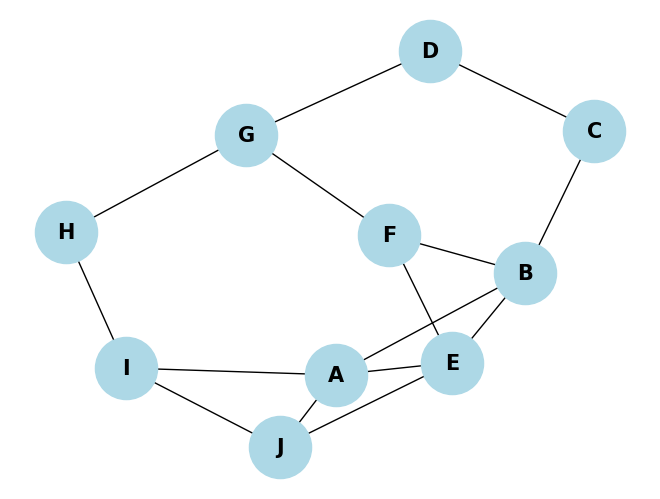

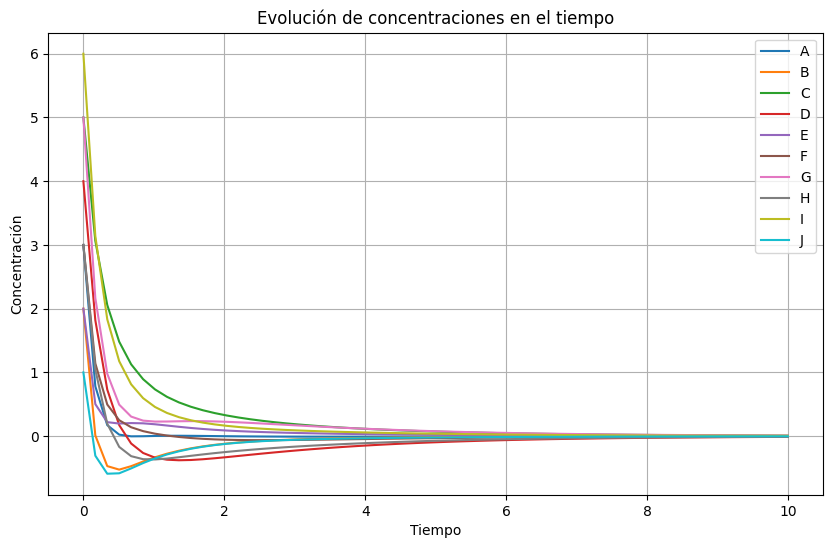

In [ ]:
A = np.array([
    [0, 1, 0, 0, 1, 0, 0, 0, 1, 1],
    [1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    [0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
])

d = np.diag([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])

C0=np.array([3,2,5,4,2,3,5,3,6,1])
Tolerancia=0.00001
Tiempo=10
Semilla=1

Difusion(A,d,C0,Tiempo,Tolerancia,Semilla,0.2, True)

Vector de concentraciones inicial:  [3 2 5 4 2 3 5]

Evolucion del vector de concentraciones: 

                  A         B         C         D         E         F  \
Tiempo                                                                  
0.000000   3.000000  2.000000  5.000000  4.000000  2.000000  3.000000   
0.169492   1.564275  0.564275  2.989264  1.989264  0.566703  1.410797   
0.338983   0.894326 -0.105674  1.909623  0.909623 -0.090970  0.621525   
0.508475   0.596189 -0.403811  1.319583  0.319583 -0.365801  0.235611   
0.677966   0.474738 -0.525262  0.990152 -0.009848 -0.455488  0.052160   
0.847458   0.434386 -0.565614  0.801615 -0.198385 -0.458956 -0.030453   
1.016949   0.429078 -0.570922  0.690727 -0.309273 -0.425212 -0.063515   
1.186441   0.437198 -0.562802  0.623621 -0.376379 -0.378113 -0.072807   
1.355932   0.449024 -0.550976  0.581850 -0.418150 -0.328907 -0.071200   
1.525424   0.460518 -0.539482  0.555156 -0.444844 -0.282575 -0.065046   
1.694915   0.470264 -0.52973

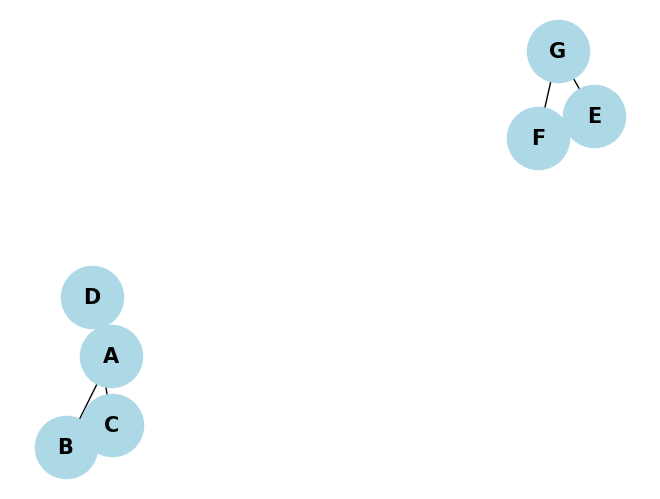

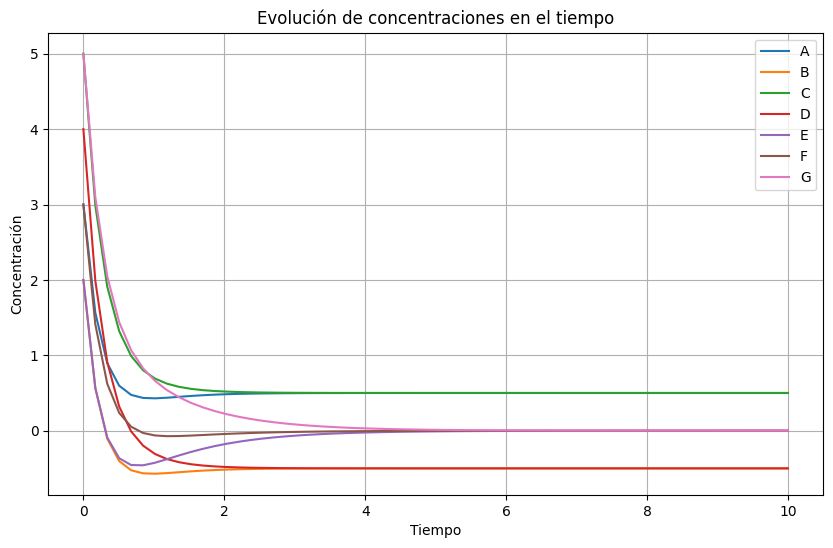

In [ ]:
A = np.array([
    [0, 1, 0, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 0]
])

d = np.diag([-1,-1,-1,-1,-1,-1,-1])

C0=np.array([3,2,5,4,2,3,5])
#C0=np.array([0,0,0,0,0,0,0,0,0,20])
Tolerancia=0.00001
Tiempo=10
Semilla=1

Difusion(A,d,C0,Tiempo,Tolerancia,Semilla,0.2,True)


Vector de concentraciones inicial:  [3 2 5 4 2 3 5 2 3 4]

Evolucion del vector de concentraciones: 

                  A         B         C         D         E         F  \
Tiempo                                                                  
0.000000   3.000000  2.000000  5.000000  4.000000  2.000000  3.000000   
0.169492   1.564275  0.564275  2.989264  1.989264  0.689208  1.400440   
0.338983   0.894326 -0.105674  1.909623  0.909623  0.091212  0.590939   
0.508475   0.596189 -0.403811  1.319583  0.319583 -0.156958  0.183630   
0.677966   0.474738 -0.525262  0.990152 -0.009848 -0.237087 -0.019163   
0.847458   0.434386 -0.565614  0.801615 -0.198385 -0.239604 -0.118208   
1.016949   0.429078 -0.570922  0.690727 -0.309273 -0.209002 -0.164865   
1.186441   0.437198 -0.562802  0.623621 -0.376379 -0.166753 -0.185295   
1.355932   0.449024 -0.550976  0.581850 -0.418150 -0.122877 -0.192798   
1.525424   0.460518 -0.539482  0.555156 -0.444844 -0.081742 -0.194116   
1.694915   0.470264 -0

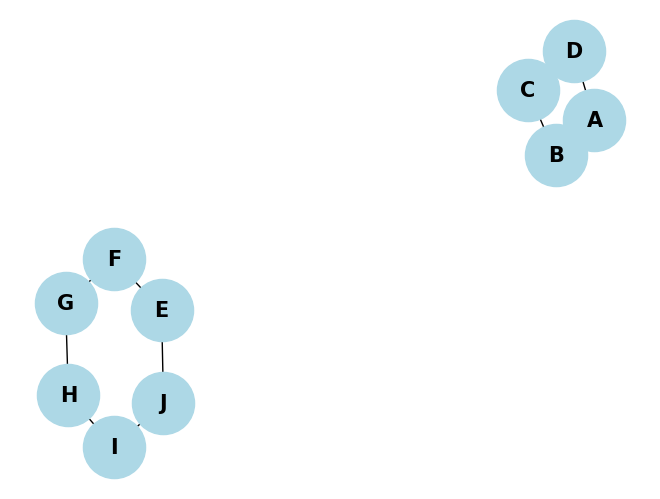

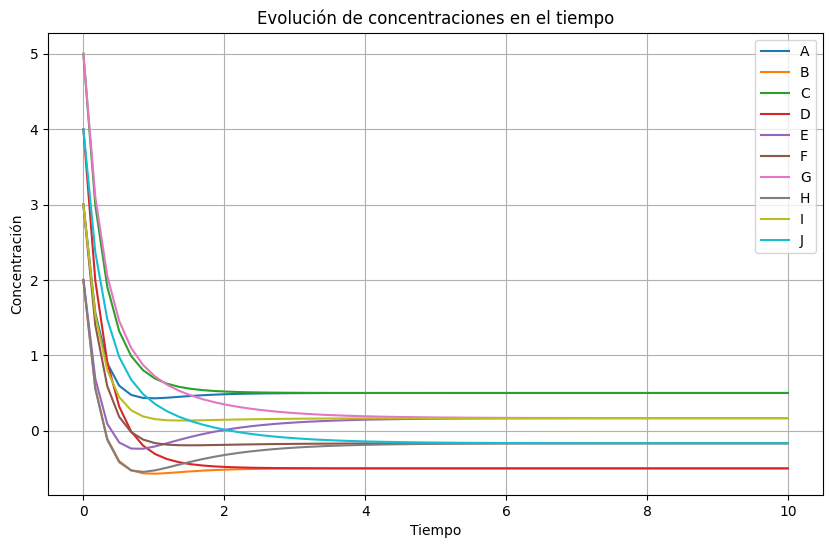

In [ ]:
A = np.array([
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
])

d = np.diag([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])

C0=np.array([3,2,5,4,2,3,5,2,3,4])
#C0=np.array([0,0,0,0,0,0,0,0,0,20])
Tolerancia=0.00001
Tiempo=10
Semilla=1

Difusion(A,d,C0,Tiempo,Tolerancia,Semilla,0.2,True)

Vector de concentraciones inicial:  [10  2 30  6 15 21 19 11 25  0 14  6 17 21 19]

Evolucion del vector de concentraciones: 

                   A         B          C         D          E          F  \
Tiempo                                                                      
0.000000   10.000000  2.000000  30.000000  6.000000  15.000000  21.000000   
0.169492    3.730703 -3.022049  20.612581  0.360424   8.354155  12.629122   
0.338983    0.757919 -4.942037  15.007810 -2.119684   5.157086   8.202976   
0.508475   -0.574106 -5.385404  11.454140 -3.105955   3.659984   5.830164   
0.677966   -1.100814 -5.162001   9.052155 -3.412299   2.989675   4.535917   
0.847458   -1.242010 -4.670034   7.328049 -3.429352   2.713300   3.814989   
1.016949   -1.207176 -4.100750   6.026759 -3.339355   2.618531   3.403478   
1.186441   -1.099586 -3.542034   5.006534 -3.223378   2.602863   3.162134   
1.355932   -0.969078 -3.030734   4.185061 -3.114421   2.618024   3.016501   
1.525424   -0.838768 -2.57

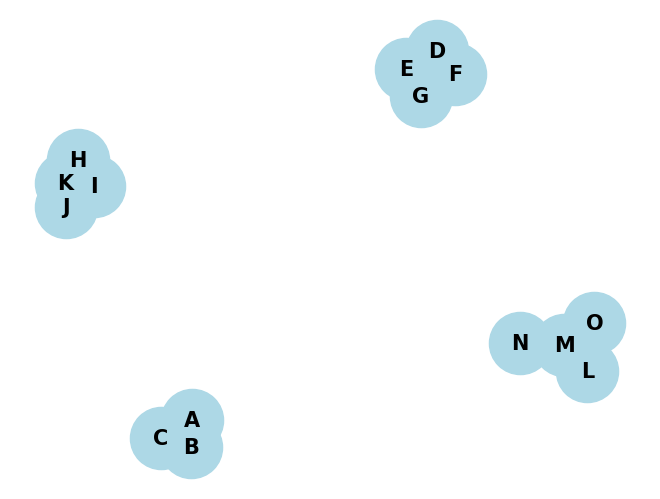

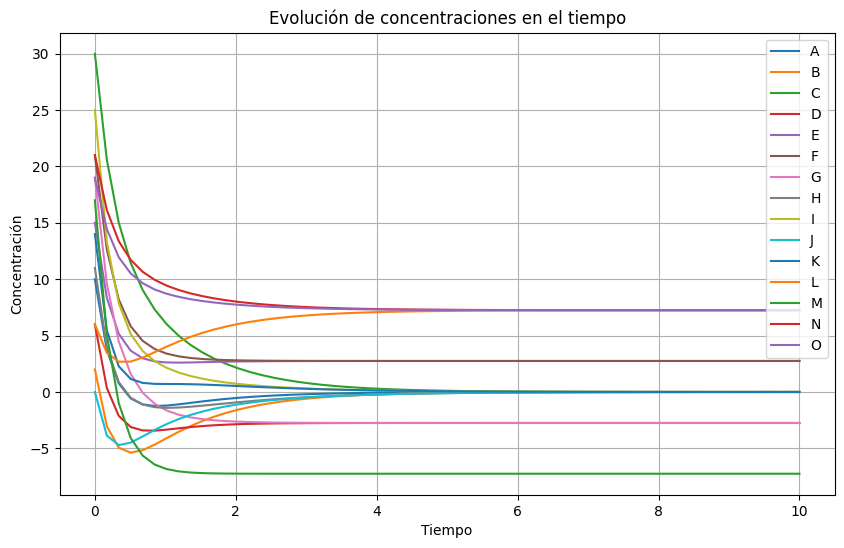

In [ ]:
A = np.array([
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
])

d = np.diag([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])

#C0=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
C0=np.array([10,2,30,6,15,21,19,11,25,0,14,6,17,21,19])
#C0=np.array([0,0,0,0,0,0,0,0,0,20])
Tolerancia=0.00001
Tiempo=10
Semilla=1

Difusion(A,d,C0,Tiempo,Tolerancia,Semilla,0.2,True)

In [ ]:
np.round(np.sort(np.real(eigenvalores)),6)

array([0.      , 0.742082, 1.246017, 1.448656, 2.      , 2.341593,
       3.568067, 4.876577, 5.412046, 6.364963])

Vector de concentraciones inicial:  [100   8   6   5   4]

Evolucion del vector de concentraciones: 

                    A         B          C    D          E
Tiempo                                                    
0.000000   100.000000  8.000000   6.000000  5.0   4.000000
0.169492    60.930363 -4.619134  -6.814273  5.0  -8.239262
0.338983    40.147945 -6.555712 -11.012236  5.0 -12.027533
0.508475    28.125420 -5.150680 -11.779410  5.0 -12.502804
0.677966    20.600982 -3.108057 -11.240634  5.0 -11.756048
0.847458    15.576446 -1.316115 -10.260704  5.0 -10.627933
1.016949    12.054047  0.018190  -9.186030  5.0  -9.447679
1.186441     9.496877  0.921395  -8.150170  5.0  -8.336593
1.355932     7.592828  1.482843  -7.199722  5.0  -7.332548
1.525424     6.147473  1.794143  -6.346197  5.0  -6.440835
1.694915     5.032871  1.931147  -5.587373  5.0  -5.654802
1.864407     4.161409  1.951448  -4.916064  5.0  -4.964107
2.033898     3.471414  1.896829  -4.323694  5.0  -4.357924
2.203390     

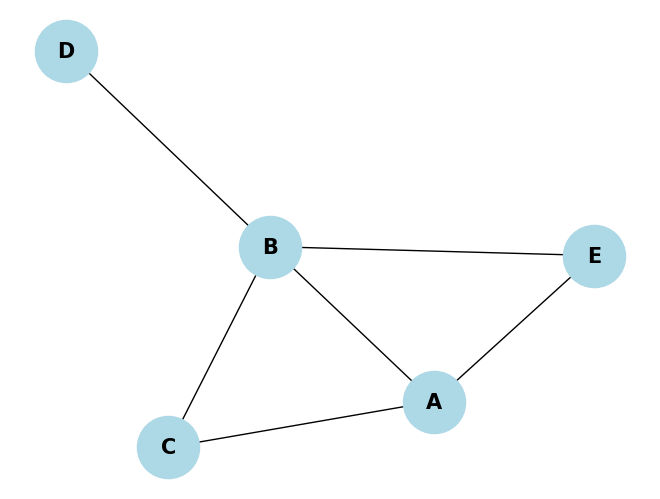

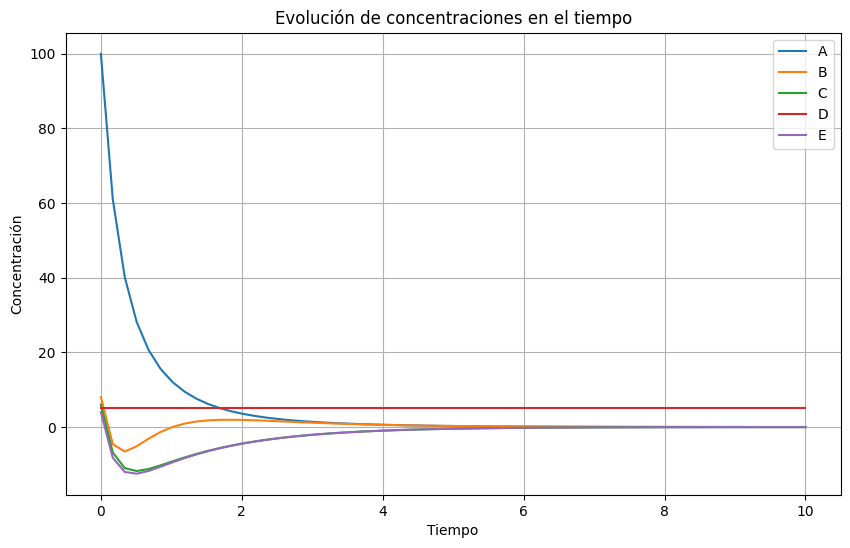

In [ ]:
# Definir la matriz A
A = np.array([
    [0,1,1,0,1],
    [1,0,1,1,1],
    [1,1,0,0,0],
    [0,1,0,0,0],
    [1,1,0,0,0],
])


d=np.diag([-1,-1,-1,-1,0,-1])
C0=np.array([100,8,6,5,4])
Tolerancia=0.0001
Tiempo=10

Difusion(A,d,C0,Tiempo,Tolerancia,2,0.2,True)

[[-1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0 -1]]
Vector de concentraciones inicial:  [25 35 40 35]

Evolucion del vector de concentraciones: 

                   A          B          C          D
Tiempo                                               
0.000000   25.000000  35.000000  40.000000  35.000000
0.508475   -9.404942   8.273457  24.143372   8.273457
1.016949  -10.272911   4.535512  18.689812   4.535512
1.525424   -8.437950   3.371963  14.945282   3.371963
2.033898   -6.754285   2.653948  11.976606   2.653948
2.542373   -5.397952   2.112419   9.591837   2.112419
3.050847   -4.316127   1.686711   7.678353   1.686711
3.559322   -3.452407   1.348400   6.145157   1.348400
4.067797   -2.762048   1.078495   4.917573   1.078495
4.576271   -2.209930   0.862811   3.935023   0.862811
5.084746   -1.768247   0.690332   3.148720   0.690332
5.593220   -1.414866   0.552357   2.519511   0.552357
6.101695   -1.132116   0.441969   2.016029   0.441969
6.610169   -0.905875   0.353644   1

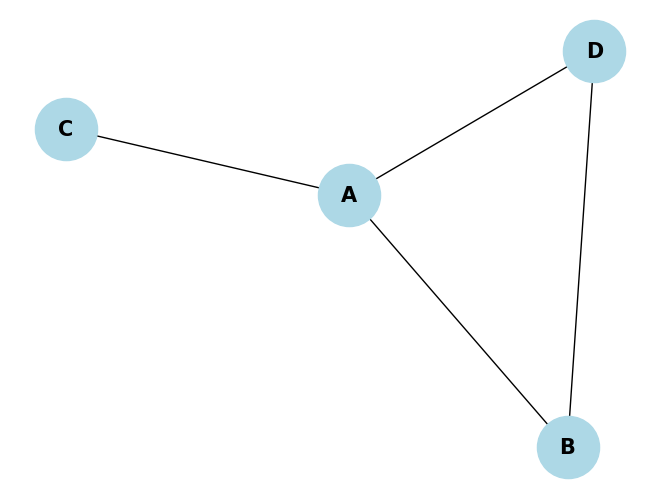

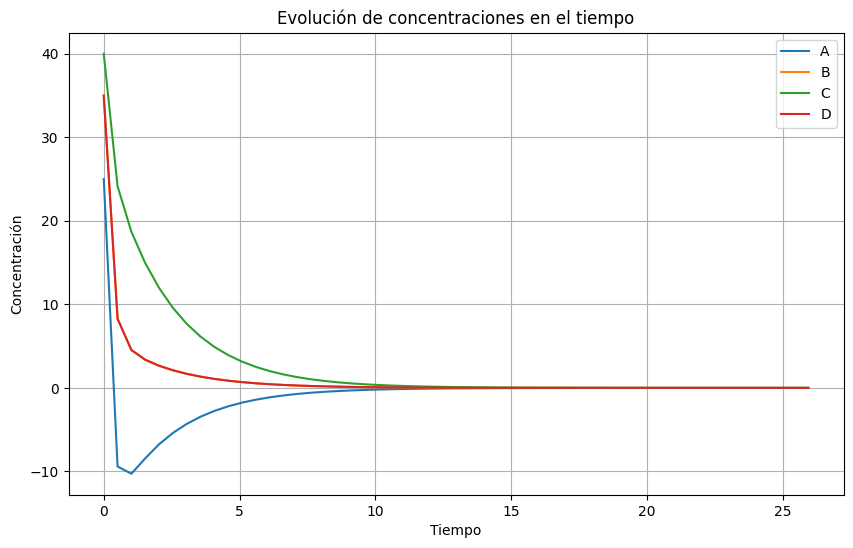

In [ ]:
A = np.array([
    [0,1,1,1],
    [1,0,0,1],
    [1,0,0,0],
    [1,1,0,0],
])


d=np.diag([-1,-1,-1,-1])
print(d)
C0=np.array([25,35,40,35])
Tolerancia=0.0001
Tiempo=30


Difusion(A,d,C0,Tiempo,Tolerancia,2,0.2,True)